In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.Rotate(limit=20),  # Random rotation between -20 and 20 degrees
        albu.GaussianBlur(p=0.3),
        albu.HueSaturationValue(p=0.3),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'test': albu.Compose([   # Generally, you don't augment test data. Just resize and normalize.
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Split the data into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])
test_dataset = BrainCTDataset(test_images, test_labels, transform=data_transforms['test'])


# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'valid': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of train images: 4167
Number of validation images: 893
Number of test images: 893


Training Images:


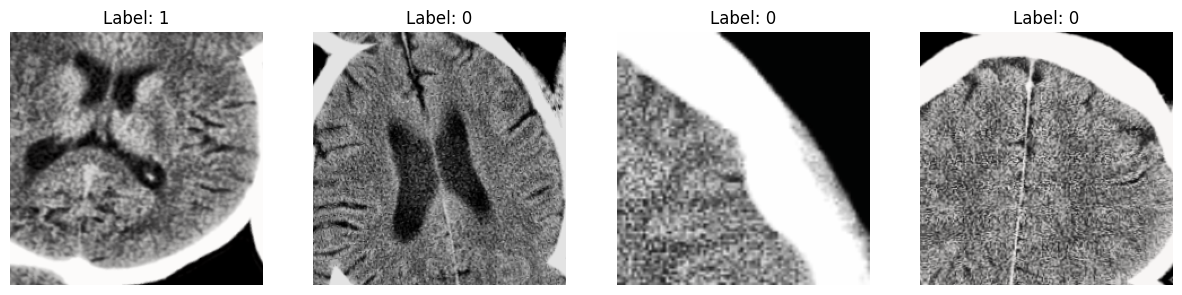

In [4]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# # Visualize random images from validation dataset
# print("Validation Images:")
# visualize_random_images(dataloaders['valid'])

# # Visualize random images from test dataset
# print("Testing Images:")
# visualize_random_images(dataloaders['test'])


## feature extraction Densnet201


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.densenet201(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
model.classifier = nn.Sequential(
    nn.Linear(1920, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 2),
)

model = model.to(device)


cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (9,408)
│    └─BatchNorm2d: 2-2                  (128)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             (45,440)
│    │    └─_DenseLayer: 3-2             (49,600)
│    │    └─_DenseLayer: 3-3             (53,760)
│    │    └─_DenseLayer: 3-4             (57,920)
│    │    └─_DenseLayer: 3-5             (62,080)
│    │    └─_DenseLayer: 3-6             (66,240)
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             (512)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (32,768)
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            (53,760)
│    │    └─

In [7]:
import time
import copy
from tqdm.auto import tqdm

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 1
    best_loss = float('inf') 
    no_improve = 0 
    early_stop = False

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset),
        'test': len(test_dataset)
    }

    model.to(device)

    for epoch in tqdm(range(1, num_epochs+1)):
        epoch_start_time = time.time()

        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                _, preds = torch.max(outputs.detach(), 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch % 10 == 0:
                print('{} Loss at epoch {}: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch, epoch_loss, epoch_acc))

            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch} with best valid accuracy of {best_acc:.4f}.")
                    early_stop = True
                    break
        if early_stop:
            break
        
        scheduler.step()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        if epoch % 10 == 0:
            print('Epoch completed in {:.0f}m {:.0f}s'.format(epoch_duration // 60, epoch_duration % 60))
            print()

    time_elapsed = time.time() - since

    if epoch % 10 == 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best valid accuracy: {:4f} achieved at epoch {}'.format(best_acc, best_epoch))

    model.load_state_dict(best_model_wts)

    # Evaluate the model on test data
    model.eval()
    running_corrects = 0
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    test_acc = running_corrects.double() / dataset_sizes['test']
    print('Test Accuracy: {:4f}'.format(test_acc))

    return model, history


In [9]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001,weight_decay=0.0001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=200)


  4%|▍         | 9/200 [15:39<4:44:35, 89.40s/it] 

Epoch 10/200
----------


  5%|▌         | 10/200 [16:08<3:43:14, 70.49s/it]

valid Loss at epoch 10: 0.5728 Acc: 0.7032
Epoch completed in 0m 28s



  8%|▊         | 16/200 [19:24<3:43:07, 72.76s/it]

Early stopping at epoch 17. Best epoch was 12 with best valid accuracy of 0.6920.


Test Accuracy: 0.692049


In [10]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[431  90]
 [185 187]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       521
           1       0.68      0.50      0.58       372

    accuracy                           0.69       893
   macro avg       0.69      0.66      0.67       893
weighted avg       0.69      0.69      0.68       893



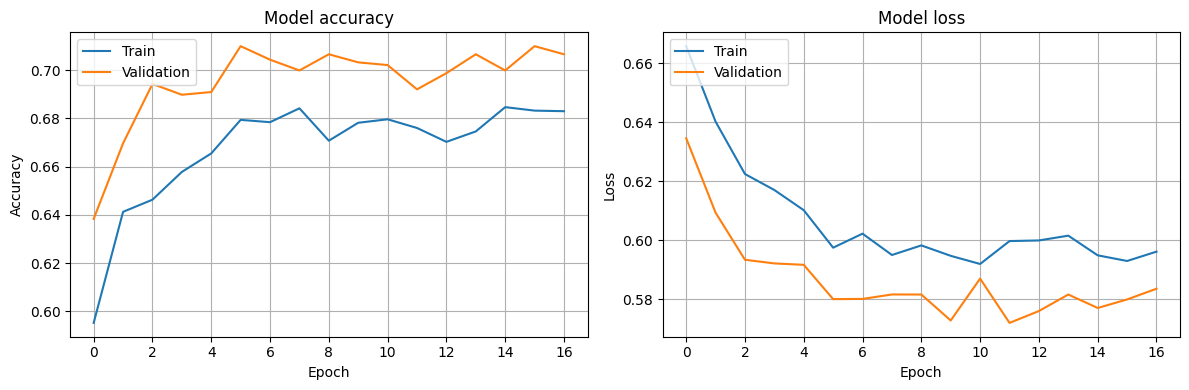

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [12]:
# Assuming you have already run train_model like this:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=200, patience=5)

bestmodel = {
    'model': model,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_loss': history['train_loss'],
    'valid_loss': history['valid_loss'],
    'train_acc': history['train_acc'],
    'valid_acc': history['valid_acc']
    # Note: I've noticed you mentioned test loss and accuracy too, but from the provided function, 
    # we only have train and valid loss/accuracy. If you have test loss and accuracy separately, 
    # you can add them similarly.
}

torch.save(bestmodel, 'HemorrhageDensnet201_Truncate.pth')


  2%|▎         | 5/200 [02:47<1:48:50, 33.49s/it]

Early stopping at epoch 6. Best epoch was 1 with best valid accuracy of 0.6999.


Test Accuracy: 0.690929


In [13]:
loaded_data = torch.load('HemorrhageDensnet201_Truncate.pth')
model = loaded_data['model']
model.load_state_dict(loaded_data['state_dict'])
optimizer.load_state_dict(loaded_data['optimizer'])

train_loss = loaded_data['train_loss']
valid_loss = loaded_data['valid_loss']
train_acc = loaded_data['train_acc']
valid_acc = loaded_data['valid_acc']
